In [1]:
# Required to see plots when running on mybinder
import matplotlib 
matplotlib.use('Agg')

import numpy as np
import matplotlib.pyplot as plt
from astropy.nddata import Cutout2D

%matplotlib inline 

# Python standard-libraries to download data from the web
from urllib.parse import urlencode
from urllib.request import urlretrieve

#Some astropy submodules that you know already
from astropy import units as u
from astropy import coordinates as coords
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.wcs import WCS

#only here to display images
from IPython.display import Image

# These are the new modules for this notebook
from astroquery.simbad import Simbad
from astroquery.sdss import SDSS

In [2]:
#Find a spectrum using astroquery
galaxy_name="Id1"
pos = coords.SkyCoord('146.75035d 25.6793d', frame='icrs')
result = SDSS.query_region(pos, spectro=True)
result

/obs/salome/anaconda3/envs/ipykernel_py3/lib/python3.7/site-packages/astroquery/sdss/core.py:865: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  comments='#'))


ra,dec,objid,run,rerun,camcol,field,z,plate,mjd,fiberID,specobjid,run2d,instrument
float64,float64,int64,int64,int64,int64,int64,float64,int64,int64,int64,int64,int64,bytes4
146.750360137564,25.6793708392606,1237667255611555987,5071,301,6,220,0.1090429,2297,53738,6,2586193797998209024,26,SDSS


In [3]:
im_size = 3*u.arcmin # get a 25 arcmin square
im_pixels = 1024
cutoutbaseurl = 'http://skyservice.pha.jhu.edu/DR12/ImgCutout/getjpeg.aspx'
query_string = urlencode(dict(ra=pos.ra.deg,
                              dec=pos.dec.deg,
                              width=im_pixels, height=im_pixels,
                              scale=im_size.to(u.arcsec).value/im_pixels))
url = cutoutbaseurl + '?' + query_string

# this downloads the image
image_name = galaxy_name+'_SDSS_cutout.jpg'
urlretrieve(url, image_name)

('Id1_SDSS_cutout.jpg', <http.client.HTTPMessage at 0x7f9fa8b50410>)

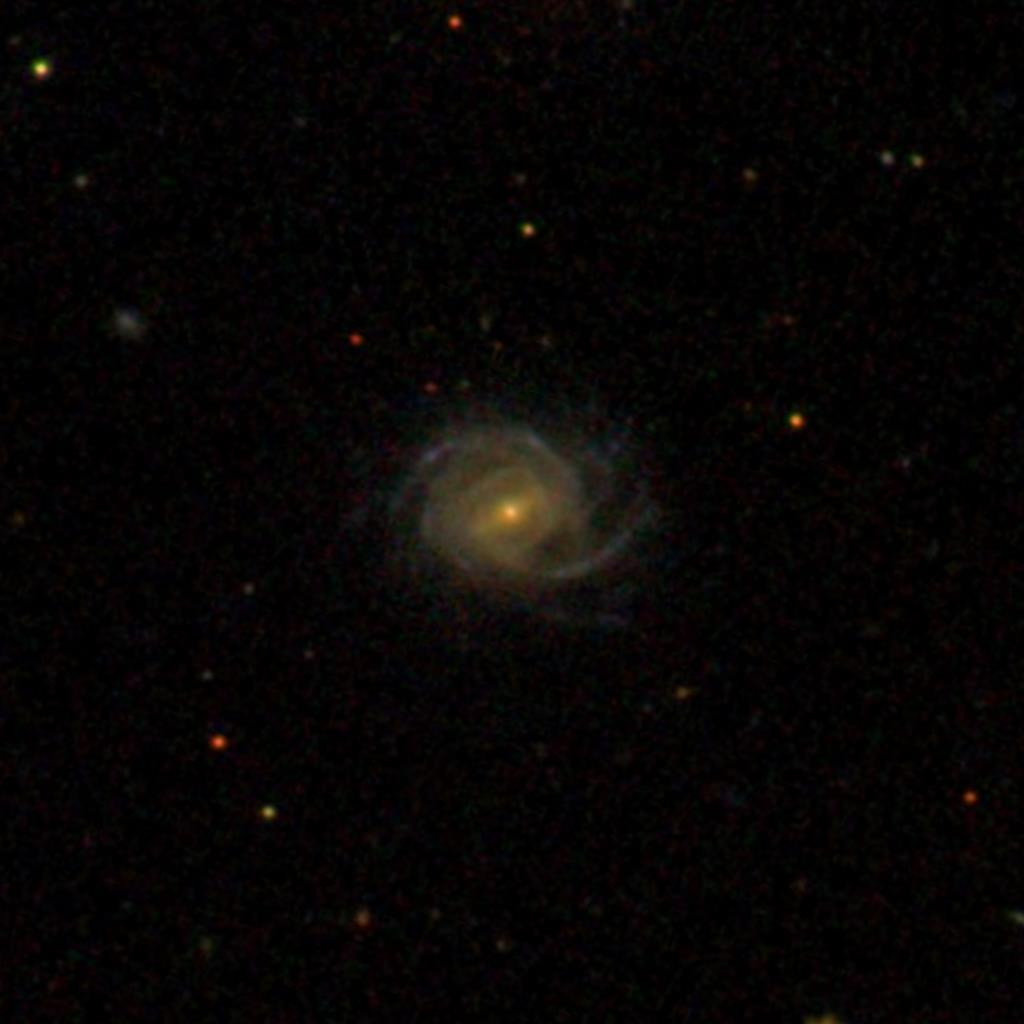

In [4]:
Image(image_name) #load the image into the notebook

In [5]:

xid = SDSS.query_region(pos, spectro=True,radius=2*u.arcsec)
spectra = SDSS.get_spectra(matches=xid)
spectra_data = spectra[0][1].data
z = 0.109   

Text(0.5, 1.0, 'SDSS spectra of Id1')

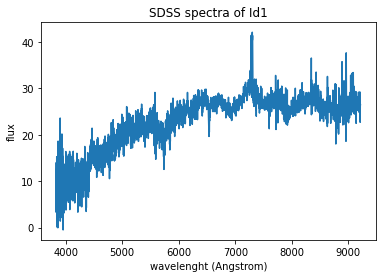

In [6]:
from astropy import constants as const
clight=const.c
plt.plot(10**spectra_data['loglam'], spectra_data['flux'])
plt.xlabel('wavelenght (Angstrom)')
plt.ylabel('flux')
plt.title('SDSS spectra of '+galaxy_name)

In [7]:
#The fourth record stores the positions of some emission lines
lines = spectra[0][3].data

In [8]:
lines['LINENAME']

chararray(['Ly_alpha', 'N_V 1240', 'C_IV 1549', 'He_II 1640',
           'C_III] 1908', 'Mg_II 2799', '[O_II] 3725', '[O_II] 3727',
           '[Ne_III] 3868', 'H_epsilon', '[Ne_III] 3970', 'H_delta',
           'H_gamma', '[O_III] 4363', 'He_II 4685', 'H_beta',
           '[O_III] 4959', '[O_III] 5007', 'He_II 5411', '[O_I] 5577',
           '[O_I] 6300', '[S_III] 6312', '[O_I] 6363', '[N_II] 6548',
           'H_alpha', '[N_II] 6583', '[S_II] 6716', '[S_II] 6730',
           '[Ar_III] 7135'], dtype='<U13')

In [9]:
for n in ['[O_II] 3727', '[O_III] 5007', 'H_alpha']:
    print(n, " ->", lines['LINEWAVE'][lines['LINENAME']==n])

[O_II] 3727  -> [3729.875448]
[O_III] 5007  -> [5008.23963773]
H_alpha  -> [6564.61389433]


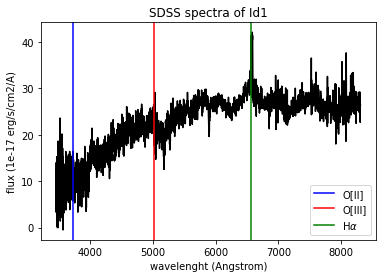

In [10]:
plt.plot(10**spectra_data['loglam']/(1+z), spectra_data['flux'], color='black')
plt.axvline(x=lines['LINEWAVE'][lines['LINENAME']=='[O_II] 3727'], label=r'O[II]', color='blue')
plt.axvline(x=lines['LINEWAVE'][lines['LINENAME']=='[O_III] 5007'], label=r'O[III]', color='red')
plt.axvline(x=lines['LINEWAVE'][lines['LINENAME']=='H_alpha'], label=r'H$\alpha$', color='green')

plt.xlabel('wavelenght (Angstrom)')
plt.ylabel('flux (1e-17 erg/s/cm2/A)')
# 1 maggy is 3.631×10-6 Jy
# 1 nanomaggy is 3.631e-15 Jy
# 1 nanomaggy is 1e-23*3.631e-15 erg/s/cm2/Hz
plt.title('SDSS spectra of '+galaxy_name)
plt.legend()

In [11]:
# Images in the different SDSS bands (u,g,r,i,z)
images = SDSS.get_images(matches=xid, band='r')

In [12]:
image_data = images[0][0].data

In [13]:
plt.figure(figsize=(10,10))
wcs = WCS(images[0][0].header)

#plt.subplot(projection=wcs)
#plt.imshow(np.log10(images[0][0].data), origin='lower')
#plt.grid(color='black', ls='solid')
#plt.xlabel('Galactic Longitude')
#plt.ylabel('Galactic Latitude')
#plt.colorbar()

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


<Figure size 720x720 with 0 Axes>

In [14]:
dim1=200
dim2=200
x_p, y_p = SkyCoord.to_pixel(pos, wcs)
cutout = Cutout2D(images[0][0].data, position=(x_p,y_p), size=(dim1,dim2), wcs=wcs.celestial)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


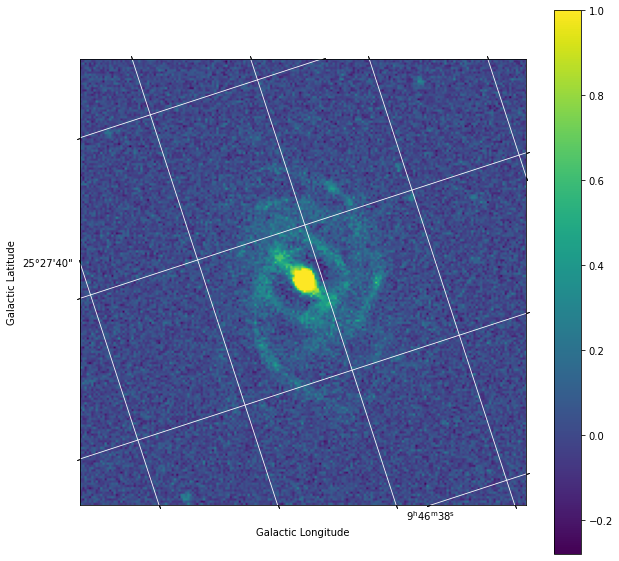

In [15]:
from skimage.filters import unsharp_mask

plt.figure(figsize=(10,10))
wcs = WCS(images[0][0].header)

galaxy = unsharp_mask(cutout.data, radius=5, amount=2)
plt.subplot(projection=wcs)
plt.imshow(galaxy, origin='lower')
plt.grid(color='white', ls='solid')
plt.xlabel('Galactic Longitude')
plt.ylabel('Galactic Latitude')
plt.colorbar()
#print(np.max(cutout.data))
#print(images[0][0].header)

In [16]:
from radialprofile import *

In [38]:
radial_prof=azimuthalAverage(cutout.data, returnradii=True)

/home/salome/AA-M2_AAIS/radialprofile.py:72: RuntimeWarning: invalid value encountered in true_divide
  radial_prof = np.histogram(r, bins, weights=(image*weights*mask))[0] / np.histogram(r, bins, weights=(mask*weights))[0]


/obs/salome/anaconda3/envs/ipykernel_py3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


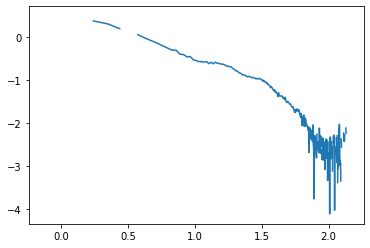

In [72]:
plt.plot(np.log10(radial_prof[0]), np.log10(radial_prof[1]))

3.9269908169872414e-05
0.0002261946710584651
2.2776546738526e-05


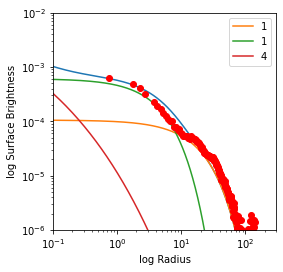

In [153]:
# Arbitrary Units
# Not a fit, just a try with 2 disks and a bulge

import numpy as np
from astropy.modeling.models import Sersic1D
import matplotlib.pyplot as plt
from math import *

plt.figure(figsize=(4,4))
plt.subplot(111, xscale='log', yscale='log')

I0=1e-8
Reff1=25
Ltot1=2*pi*I0*Reff1**2
print(Ltot1)
s1 = Sersic1D(amplitude=Ltot1/2, r_eff=Reff1)
s1.n = 1


I0=1e-6
Reff1=6
Ltot1=2*pi*I0*Reff1**2
print(Ltot1)
s1b = Sersic1D(amplitude=Ltot1/2, r_eff=Reff1)
s1b.n = 1


I0=1e-6
Reff4=1
Ltot4=7.25*pi*I0*Reff4**2
print(Ltot4)
s4 = Sersic1D(amplitude=Ltot4/2, r_eff=Reff4)
s4.n = 4

r=np.arange(0, 300, .01)

plt.plot(r, s1(r)+s4(r)+s1b(r))
plt.plot(r, s1(r), label=str(1))
plt.plot(r, s1b(r), label=str(1))
plt.plot(r, s4(r), label=str(4))

plt.plot(radial_prof[0], radial_prof[1]/5000, 'ro')
    
plt.axis([1e-1, 300, 1e-6, 1e-2])
plt.xlabel('log Radius')
plt.ylabel('log Surface Brightness')
plt.legend()
plt.show()

In [94]:
np.nanmin((radial_prof[0]))

0.25

In [95]:
r.min()

0.0